## Automated ML

Import Dependencies. 

In [1]:
import logging

from matplotlib import pyplot as plt
import pandas as pd
import os

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.automl.core.featurization import FeaturizationConfig
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig
from azureml.interpret import ExplanationClient

## Dataset

### Overview

Dataset from Davide Chicco, Giuseppe Jurman: "Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone". BMC Medical Informatics and Decision Making 20, 16 (2020)

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worlwide.
Heart failure is a common event caused by CVDs and this dataset contains 12 features that can be used to predict mortality by heart failure.

Twelve (12) clinical features:

- age: age of the patient (years)
- anaemia: decrease of red blood cells or hemoglobin (boolean)
- high blood pressure: if the patient has hypertension (boolean)
- creatinine phosphokinase (CPK): level of the CPK enzyme in the blood (mcg/L)
- diabetes: if the patient has diabetes (boolean)
- ejection fraction: percentage of blood leaving the heart at each contraction (percentage)
- platelets: platelets in the blood (kiloplatelets/mL)
- sex: woman or man (binary)
- serum creatinine: level of serum creatinine in the blood (mg/dL)
- serum sodium: level of serum sodium in the blood (mEq/L)
- smoking: if the patient smokes or not (boolean)
- time: follow-up period (days)

Most cardiovascular diseases can be prevented by addressing behavioural risk factors such as tobacco use, unhealthy diet and obesity, physical inactivity and harmful use of alcohol using population-wide strategies.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

For this task, Azure auto machine learning will be performed to make accurate prediction on the death event based on patient's 12 clinical features. 

## Review Dataset Result

In [2]:
ws = Workspace.from_config()

# choose a name for experiment
experiment_name = 'automl-classification-experiment'

experiment=Experiment(ws, experiment_name)

output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Subscription ID,374bdf1a-c648-4244-a317-f0d1ef4b85c7
Workspace,quick-starts-ws-130432
Resource Group,aml-quickstarts-130432
Location,southcentralus
Experiment Name,automl-classification-experiment


In [3]:
# Try to load the dataset from the Workspace. Otherwise, create it from the file
# NOTE: update the key to match the dataset name
found = False
key = "heart-failure"
description_text = "Clinical Record DataSet for Predicting Death Event"

if key in ws.datasets.keys(): 
        found = True
        dataset = ws.datasets[key] 

if not found:
        # Create AML Dataset and register it into Workspace
        example_data = 'https://mlstrg130254.blob.core.windows.net/azureml-blobstore-01848383-aa83-4b0d-a1e9-2957a2018b7b'
        dataset = Dataset.Tabular.from_delimited_files(example_data)        
        #Register Dataset in Workspace
        dataset = dataset.register(workspace=ws,
                                   name=key,
                                   description=description_text)


df = dataset.to_pandas_dataframe()
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [4]:
dataset.take(5).to_pandas_dataframe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Create or Attach an AmlCompute Cluster

In [5]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
cpu_cluster_name = "cpu-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D12_V2',
                                                           max_nodes=5)
    compute_target = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## AutoML Configuration

In [6]:
project_folder = './automl'

automl_settings = {
    "experiment_timeout_minutes": 30,
    "max_concurrent_iterations": 5,
    "primary_metric" : 'AUC_weighted'
}
automl_config = AutoMLConfig(compute_target=compute_target,
                             task = "classification",
                             training_data=dataset,
                             label_column_name="DEATH_EVENT", 
                             enable_onnx_compatible_models=True,
                             path = project_folder,
                             enable_early_stopping= True,
                             featurization= 'auto',
                             debug_log = "automl_errors.log",
                             **automl_settings
                            )

AutoML typically performs cross validation, data balance check, cardinality check in prior to machine learning process with a variety of algorithms. 

In [7]:
remote_run = experiment.submit(automl_config, show_output = True)

Running on remote.
No run_configuration provided, running on cpu-cluster with default configuration
Running on remote compute: cpu-cluster
Parent Run ID: AutoML_f0b7b6dc-35cc-4d69-a0d9-a7418c76228c

Current status: FeaturesGeneration. Generating features for the dataset.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Cross validation
STATUS:       DONE
DESCRIPTION:  Each iteration of the trained model was validated through cross-validation.
              
DETAILS:      
+---------------------------------+
|Number of folds                  |
+=================================+
|10                               |
+---------------------------------+

****************************************************************************************************

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were ana

In [8]:
remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-classification-experiment,AutoML_f0b7b6dc-35cc-4d69-a0d9-a7418c76228c,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [9]:
#from azureml.train.automl.run import AutoMLRun
#remote_run = AutoMLRun(experiment=experiment, run_id='AutoML_b580a705-20af-4f6c-a516-3aaede13be37')
#remote_run

In [10]:
from azureml.widgets import RunDetails

RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [11]:
# Wait for the remote run to complete
remote_run.wait_for_completion()

{'runId': 'AutoML_f0b7b6dc-35cc-4d69-a0d9-a7418c76228c',
 'target': 'cpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2020-12-14T05:40:24.463893Z',
 'endTimeUtc': '2020-12-14T05:59:59.951744Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'AUC_weighted',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'cpu-cluster',
  'AMLSettingsJsonString': '{"path":null,"name":"automl-classification-experiment","subscription_id":"374bdf1a-c648-4244-a317-f0d1ef4b85c7","resource_group":"aml-quickstarts-130432","workspace_name":"quick-starts-ws-130432","region":"southcentralus","compute_target":"cpu-cluster","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"iterations":1000,"primary_metric":"AUC_weighted","task_type":"classification","data_script":null,"validation_size":0.0,"n_cross_validations":null,"y_min":null,"y_

In [12]:
best_run_customized, fitted_model_customized = remote_run.get_output()

## Transparency

View updated featurization summary

In [13]:
custom_featurizer = fitted_model_customized.named_steps['datatransformer']
df = custom_featurizer.get_featurization_summary()
pd.DataFrame(data=df)

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations
0,age,Numeric,No,1,[MeanImputer]
1,anaemia,Numeric,No,1,[MeanImputer]
2,creatinine_phosphokinase,Numeric,No,1,[MeanImputer]
3,diabetes,Numeric,No,1,[MeanImputer]
4,ejection_fraction,Numeric,No,1,[MeanImputer]
5,high_blood_pressure,Numeric,No,1,[MeanImputer]
6,platelets,Numeric,No,1,[MeanImputer]
7,serum_creatinine,Numeric,No,1,[MeanImputer]
8,serum_sodium,Numeric,No,1,[MeanImputer]
9,sex,Numeric,No,1,[MeanImputer]


In [14]:
df = custom_featurizer.get_featurization_summary(is_user_friendly=False)
pd.DataFrame(data=df)

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations,TransformationParams
0,age,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['age'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'add_indicator': False, 'copy': True, 'fill_value': None, 'missing_values': nan, 'strategy': 'mean', 'verbose': 0}}}"
1,anaemia,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['anaemia'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'add_indicator': False, 'copy': True, 'fill_value': None, 'missing_values': nan, 'strategy': 'mean', 'verbose': 0}}}"
2,creatinine_phosphokinase,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['creatinine_phosphokinase'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'add_indicator': False, 'copy': True, 'fill_value': None, 'missing_values': nan, 'strategy': 'mean', 'verbose': 0}}}"
3,diabetes,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['diabetes'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'add_indicator': False, 'copy': True, 'fill_value': None, 'missing_values': nan, 'strategy': 'mean', 'verbose': 0}}}"
4,ejection_fraction,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['ejection_fraction'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'add_indicator': False, 'copy': True, 'fill_value': None, 'missing_values': nan, 'strategy': 'mean', 'verbose': 0}}}"
5,high_blood_pressure,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['high_blood_pressure'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'add_indicator': False, 'copy': True, 'fill_value': None, 'missing_values': nan, 'strategy': 'mean', 'verbose': 0}}}"
6,platelets,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['platelets'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'add_indicator': False, 'copy': True, 'fill_value': None, 'missing_values': nan, 'strategy': 'mean', 'verbose': 0}}}"
7,serum_creatinine,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['serum_creatinine'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'add_indicator': False, 'copy': True, 'fill_value': None, 'missing_values': nan, 'strategy': 'mean', 'verbose': 0}}}"
8,serum_sodium,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['serum_sodium'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'add_indicator': False, 'copy': True, 'fill_value': None, 'missing_values': nan, 'strategy': 'mean', 'verbose': 0}}}"
9,sex,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['sex'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'add_indicator': False, 'copy': True, 'fill_value': None, 'missing_values': nan, 'strategy': 'mean', 'verbose': 0}}}"


In [15]:
df = custom_featurizer.get_stats_feature_type_summary()
pd.DataFrame(data=df)

""


## Results

#### Retrieve the Best Model's explanation

Retrieve the explanation from the best_run which includes explanations for engineered features and raw features. Make sure that the run for generating explanations for the best model is completed

In [16]:
# Wait for the best model explanation run to complete
from azureml.core.run import Run
model_explainability_run_id = remote_run.id + "_" + "ModelExplain"
print(model_explainability_run_id)
model_explainability_run = Run(experiment=experiment, run_id=model_explainability_run_id)
model_explainability_run.wait_for_completion()

# Get the best run object
best_run, fitted_model = remote_run.get_output()

AutoML_f0b7b6dc-35cc-4d69-a0d9-a7418c76228c_ModelExplain


### Download engineered feature importance from artifact store

In [17]:
client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=False)
exp_data = engineered_explanations.get_feature_importance_dict()
exp_data

{'time_MeanImputer': 0.6004896673434018,
 'ejection_fraction_MeanImputer': 0.20318728617334736,
 'serum_creatinine_MeanImputer': 0.1955516231831254,
 'age_MeanImputer': 0.11601364040548033,
 'serum_sodium_MeanImputer': 0.10515740751841474,
 'creatinine_phosphokinase_MeanImputer': 0.041410908162943266,
 'platelets_MeanImputer': 0.03881941282542297,
 'sex_MeanImputer': 0.02768487262960952,
 'anaemia_MeanImputer': 0.025125581547287616,
 'high_blood_pressure_MeanImputer': 0.012922088873429743,
 'smoking_MeanImputer': 0.006062459206065028,
 'diabetes_MeanImputer': 0.004369317969560793}

### Download raw feature importance from artifact store

In [18]:
client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=True)
exp_data = engineered_explanations.get_feature_importance_dict()
exp_data

{'time': 0.6004896673434018,
 'ejection_fraction': 0.20318728617334736,
 'serum_creatinine': 0.1955516231831254,
 'age': 0.11601364040548033,
 'serum_sodium': 0.10515740751841474,
 'creatinine_phosphokinase': 0.041410908162943266,
 'platelets': 0.03881941282542297,
 'sex': 0.02768487262960952,
 'anaemia': 0.025125581547287616,
 'high_blood_pressure': 0.012922088873429743,
 'smoking': 0.006062459206065028,
 'diabetes': 0.004369317969560793}

## Retrieve the Best ONNX Mode

Below we select the best pipeline from our iterations. The get_output method returns the best run and the fitted model. The Model includes the pipeline and any pre-processing. Overloads on get_output allow you to retrieve the best run and fitted model for any logged metric or for a particular iteration.

Set the parameter return_onnx_model=True to retrieve the best ONNX model, instead of the Python model.

In [19]:
best_run, onnx_mdl = remote_run.get_output(return_onnx_model=True)

## Save the best ONNX model

In [20]:
from azureml.automl.runtime.onnx_convert import OnnxConverter
onnx_fl_path = "./best_automl_model.onnx"
OnnxConverter.save_onnx_model(onnx_mdl, onnx_fl_path)

## Predict with the ONNX model, using onnxruntime package

In [21]:
df_test = dataset.to_pandas_dataframe()
df_test = df_test[pd.notnull(df_test['DEATH_EVENT'])]

y_test = df_test['DEATH_EVENT']
X_test = df_test.drop(['DEATH_EVENT'], axis=1)

In [22]:
df_test

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.00,0,582,0,20,1,265000.00,1.90,130,1,0,4,1
1,55.00,0,7861,0,38,0,263358.03,1.10,136,1,0,6,1
2,65.00,0,146,0,20,0,162000.00,1.30,129,1,1,7,1
3,50.00,1,111,0,20,0,210000.00,1.90,137,1,0,7,1
4,65.00,1,160,1,20,0,327000.00,2.70,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.00,0,61,1,38,1,155000.00,1.10,143,1,1,270,0
295,55.00,0,1820,0,38,0,270000.00,1.20,139,0,0,271,0
296,45.00,0,2060,1,60,0,742000.00,0.80,138,0,0,278,0
297,45.00,0,2413,0,38,0,140000.00,1.40,140,1,1,280,0


In [23]:
import sys
import json
from azureml.automl.core.onnx_convert import OnnxConvertConstants
from azureml.train.automl import constants

if sys.version_info < OnnxConvertConstants.OnnxIncompatiblePythonVersion:
    python_version_compatible = True
else:
    python_version_compatible = False

import onnxruntime
from azureml.automl.runtime.onnx_convert import OnnxInferenceHelper

def get_onnx_res(run):
    res_path = 'onnx_resource.json'
    run.download_file(name=constants.MODEL_RESOURCE_PATH_ONNX, output_file_path=res_path)
    with open(res_path) as f:
        onnx_res = json.load(f)
    return onnx_res

if python_version_compatible:
    test_df = X_test
    mdl_bytes = onnx_mdl.SerializeToString()
    onnx_res = get_onnx_res(best_run)

    onnxrt_helper = OnnxInferenceHelper(mdl_bytes, onnx_res)
    pred_onnx, pred_prob_onnx = onnxrt_helper.predict(test_df)

    print(pred_onnx)
    print(pred_prob_onnx)
else:
    print('Please use Python version 3.6 or 3.7 to run the inference helper.')

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0
 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[[0.17312749 0.8268725 ]
 [0.2599318  0.7400682 ]
 [0.19087669 0.80912334]
 [0.19180557 0.80819446]
 [0.18881291 0.81118715]
 [0.19529    0.80471003]
 [0.1928269  0.80717313]
 [0.28301162 0.7169884 ]
 [0.28321105 0.716789  ]
 [0.18778682 0.8122132 ]
 [0.21679813 0.78320193]
 [0.24306783 0.7569322 ]
 [0.2656434  0.73435664]
 [0.28790492 0.7120951 ]
 [0.3835716  0.6164284 ]
 [0.20925274 0.79

## Deploy

Retrieve the Best Model
Below we select the best pipeline from our iterations. The get_output method returns the best run and the fitted model. Overloads on get_output allow you to retrieve the best run and fitted model for any logged metric or for a particular iteration.

Widget for Monitoring Runs
The widget will first report a "loading" status while running the first iteration. After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.

Note: The widget displays a link at the bottom. Use this link to open a web interface to explore the individual run details

In [24]:
best_run, fitted_model = remote_run.get_output()

In [25]:
best_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-classification-experiment,AutoML_f0b7b6dc-35cc-4d69-a0d9-a7418c76228c_38,azureml.scriptrun,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [27]:
best_run.get_file_names()

['accuracy_table',
 'automl_driver.py',
 'azureml-logs/55_azureml-execution-tvmps_386cd591818a97fa05c7d384498fb27bd5420b8926e28a97cbb4394352432c29_d.txt',
 'azureml-logs/65_job_prep-tvmps_386cd591818a97fa05c7d384498fb27bd5420b8926e28a97cbb4394352432c29_d.txt',
 'azureml-logs/70_driver_log.txt',
 'azureml-logs/75_job_post-tvmps_386cd591818a97fa05c7d384498fb27bd5420b8926e28a97cbb4394352432c29_d.txt',
 'azureml-logs/process_info.json',
 'azureml-logs/process_status.json',
 'confusion_matrix',
 'explanation/b1667c24/classes.interpret.json',
 'explanation/b1667c24/eval_data_viz.interpret.json',
 'explanation/b1667c24/expected_values.interpret.json',
 'explanation/b1667c24/features.interpret.json',
 'explanation/b1667c24/global_names/0.interpret.json',
 'explanation/b1667c24/global_rank/0.interpret.json',
 'explanation/b1667c24/global_values/0.interpret.json',
 'explanation/b1667c24/local_importance_values.interpret.json',
 'explanation/b1667c24/per_class_names/0.interpret.json',
 'explanation/b1667c24/per_class_rank/0.interpret.json',
 'explanation/b1667c24/per_class_values/0.interpret.json',
 'explanation/b1667c24/rich_metadata.interpret.json',
 'explanation/b1667c24/visualization_dict.interpret.json',
 'explanation/b1667c24/ys_pred_proba_viz.interpret.json',
 'explanation/b1667c24/ys_pred_viz.interpret.json',
 'explanation/f13ec3f4/classes.interpret.json',
 'explanation/f13ec3f4/eval_data_viz.interpret.json',
 'explanation/f13ec3f4/expected_values.interpret.json',
 'explanation/f13ec3f4/features.interpret.json',
 'explanation/f13ec3f4/global_names/0.interpret.json',
 'explanation/f13ec3f4/global_rank/0.interpret.json',
 'explanation/f13ec3f4/global_values/0.interpret.json',
 'explanation/f13ec3f4/local_importance_values.interpret.json',
 'explanation/f13ec3f4/per_class_names/0.interpret.json',
 'explanation/f13ec3f4/per_class_rank/0.interpret.json',
 'explanation/f13ec3f4/per_class_values/0.interpret.json',
 'explanation/f13ec3f4/rich_metadata.interpret.json',
 'explanation/f13ec3f4/visualization_dict.interpret.json',
 'logs/azureml/104_azureml.log',
 'logs/azureml/azureml_automl.log',
 'logs/azureml/dataprep/python_span_23617d3c-7da4-4030-b419-f0d42e6cee5c.jsonl',
 'logs/azureml/dataprep/python_span_7264072f-fd48-45b3-9e4b-e9c064630300.jsonl',
 'logs/azureml/job_prep_azureml.log',
 'logs/azureml/job_release_azureml.log',
 'outputs/conda_env_v_1_0_0.yml',
 'outputs/env_dependencies.json',
 'outputs/model.onnx',
 'outputs/model.pkl',
 'outputs/model_onnx.json',
 'outputs/pipeline_graph.json',
 'outputs/scoring_file_v_1_0_0.py']

In [26]:
model_name = best_run.properties['model_name']

script_file_name = 'inference/score.py'

best_run.download_file('outputs/scoring_file_v_1_0_0.py', 'inference/score.py')

## Register the Fitted Model for Deployment

In [28]:
description = 'AutoML Model trained on bank marketing data to predict if a client will subscribe to a term deposit'
tags = None
model = remote_run.register_model(model_name = model_name, description = description, tags = tags)

print(remote_run.model_id) # This will be written to the script file later in the notebook

AutoMLf0b7b6dc338


## Deploy the model as a Web Service on Azure Container Instance

In [29]:
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment

inference_config = InferenceConfig(entry_script=script_file_name)

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {'area': "bmData", 'type': "automl_classification"}, 
                                               description = 'sample service for Automl Classification')

aci_service_name = 'automl-heart-failure'
print(aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

automl-heart-failure
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running......................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


## Get Logs from a Deployed Web Service

In [30]:
aci_service.get_logs()

'2020-12-14T06:14:19,523092400+00:00 - rsyslog/run \n2020-12-14T06:14:19,533419200+00:00 - iot-server/run \n2020-12-14T06:14:19,535263400+00:00 - nginx/run \n/usr/sbin/nginx: /azureml-envs/azureml_7cf2b5eebfc9a832d561ce064cfbc38b/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_7cf2b5eebfc9a832d561ce064cfbc38b/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_7cf2b5eebfc9a832d561ce064cfbc38b/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_7cf2b5eebfc9a832d561ce064cfbc38b/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_7cf2b5eebfc9a832d561ce064cfbc38b/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n2020-12-14T06:14:19,576370400+00:00 - gunicorn/run 

## Test

Now that the model is trained, run the test data through the trained model to get the predicted values. This calls the ACI web service to do the prediction.

Note that the JSON passed to the ACI web service is an array of rows of data. Each row should either be an array of values in the same order that was used for training or a dictionary where the keys are the same as the column names used for training. The example below uses dictionary rows.

In [31]:
from numpy import array

X_test = dataset.drop_columns(columns=['DEATH_EVENT'])
y_test = dataset.keep_columns(columns=['DEATH_EVENT'], validate=True)
dataset.take(5).to_pandas_dataframe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.00,0,582,0,20,1,265000.00,1.90,130,1,0,4,1
1,55.00,0,7861,0,38,0,263358.03,1.10,136,1,0,6,1
2,65.00,0,146,0,20,0,162000.00,1.30,129,1,1,7,1
3,50.00,1,111,0,20,0,210000.00,1.90,137,1,0,7,1
4,65.00,1,160,1,20,0,327000.00,2.70,116,0,0,8,1


In [32]:

X_test = X_test.to_pandas_dataframe()
y_test = y_test.to_pandas_dataframe()

In [33]:
import json
import requests

X_test_json = X_test.to_json(orient='records')
data = "{\"data\": " + X_test_json +"}"
headers = {'Content-Type': 'application/json'}

resp = requests.post(aci_service.scoring_uri, data, headers=headers)

y_pred = json.loads(json.loads(resp.text))['result']

In [34]:

actual = array(y_test)
actual = actual[:,0]
print(len(y_pred), " ", len(actual))

299   299


## Calculate metrics for the prediction

Now visualize the data as a confusion matrix that compared the predicted values against the actual values.

<IPython.core.display.Javascript object>


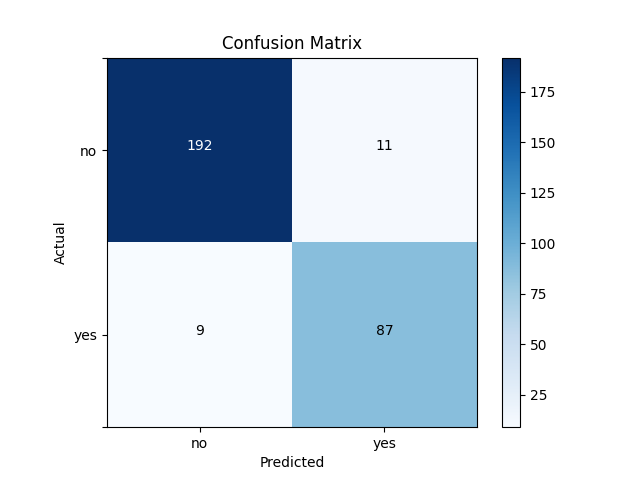

In [35]:
%matplotlib notebook
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

cf =confusion_matrix(actual,y_pred)
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
class_labels = ['no','yes']
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks,class_labels)
plt.yticks([-0.5,0,1,1.5],['','no','yes',''])
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()

## Delete a Web Service (i.e. endpoint)

In [36]:
aci_service.delete()